# Speech Augmentations

Credits to https://github.com/markovka17/apdl/blob/master/week02/

В этом ноутбуке рассмотрим базовые аугментации для звуковых сигналов:

    1) Гауссовый шум
    2) Ускорение/замедление
    3) Сдвиг питча
    4) Изменение громкости
    5) Добавление фонового шума
    6) Аугментации над спектром (Time/Freq masking, Cutout)

Обратите внимание на библиотеки с аугментациями:
1. [`SpeechBrain`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.processing.speech_augmentation.html)
2. [`torchaudio`](https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html)
3. [`librosa`](https://librosa.org/doc/latest/effects.html)

---

In [ ]:
!wget https://github.com/dmylzenova/speech_processing/raw/autumn_23/week05/LJ001-0001.wav

In [ ]:
from IPython import display
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
import torchaudio

import librosa

In [ ]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr, normalize=False))

In [ ]:
wav, sr = torchaudio.load('LJ001-0001.wav')

# Ground Truth

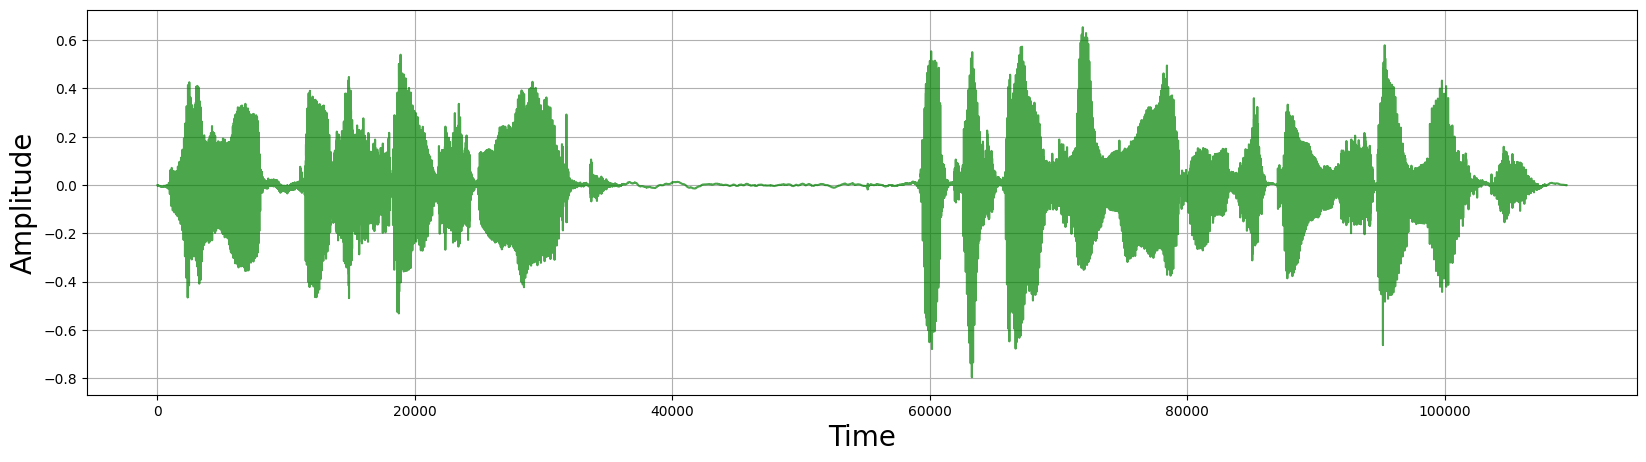

In [ ]:
visualize_audio(wav)

# Gaussian Noise

Простейшая аугментация, встречающаяся в обработке изображений - добавление нормального/гауссовского шума.

In [ ]:
from torch import distributions

In [ ]:
noiser = distributions.Normal(0, 0.05)

In [ ]:
augumented_wav_1 = wav + noiser.sample(wav.size())

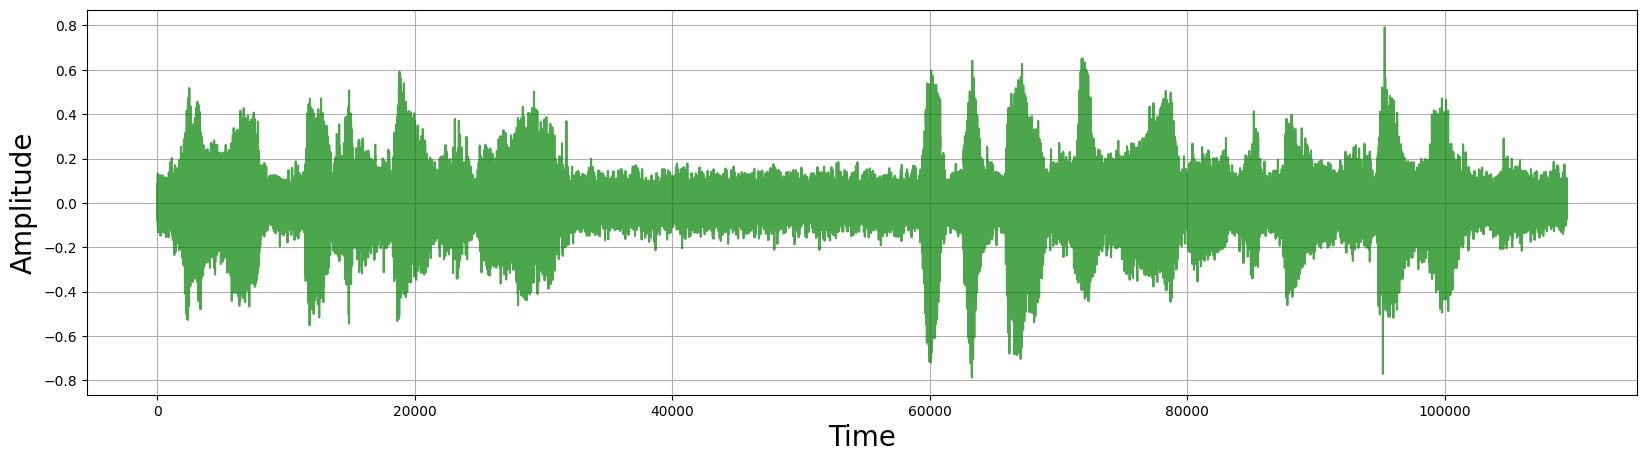

In [ ]:
visualize_audio(augumented_wav_1)

# Time Stretching

Изменение скорости.

Есть два способа применить `Time Stretching`:

1)  `librosa.effects.time_stretch` из библиотеки `librosa` , работает с `wav`

2)  `torchaudio.transforms.TimeStretch` из библиотеки `torchaudio`, работает с спектрограммами.
В этом случаен нужно применить STFT and iSTFT (обратное STFT)

In [ ]:
augumented_wav_2 = librosa.effects.time_stretch(wav.numpy().squeeze(), rate=1.7)
augumented_wav_2 = torch.from_numpy(augumented_wav_2)

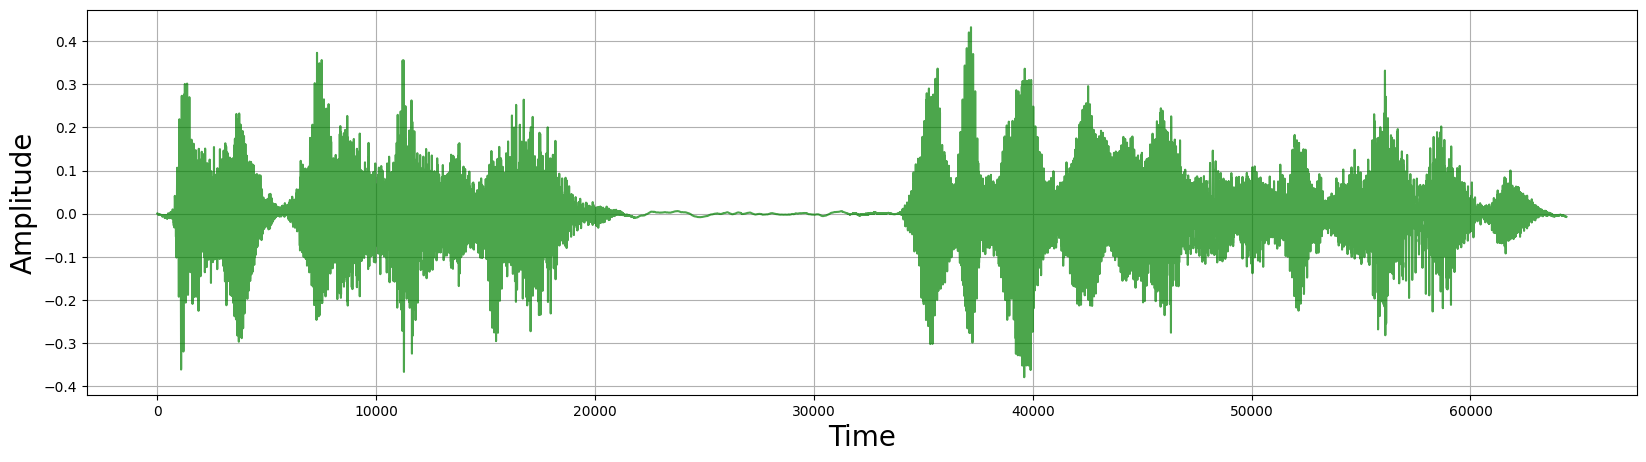

In [ ]:
visualize_audio(augumented_wav_2)

# Pitch Shifting

Эта аугментация меняет питч голоса. Например, делает его более низким или высоким. [Подробнее](https://www.dafx.de/paper-archive/2000/pdf/Bernardini.pdf.)

In [ ]:
augumented_wav_3 = librosa.effects.pitch_shift(wav.numpy().squeeze(), sr=sr, n_steps=5)
augumented_wav_3 = torch.from_numpy(augumented_wav_3)

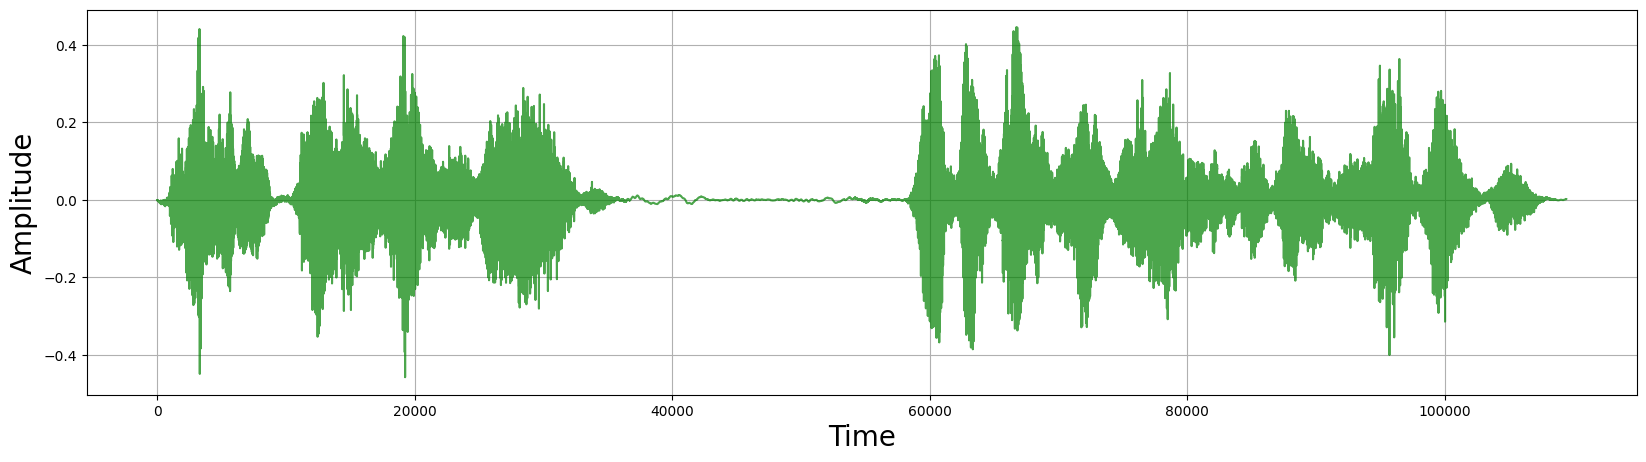

In [ ]:
visualize_audio(augumented_wav_3)

# Volume

Изменение громкости. Простая, но полезная аугментация.

In [ ]:
voler = torchaudio.transforms.Vol(gain=1.2, gain_type='amplitude')

In [ ]:
augumented_wav_4 = voler(wav)

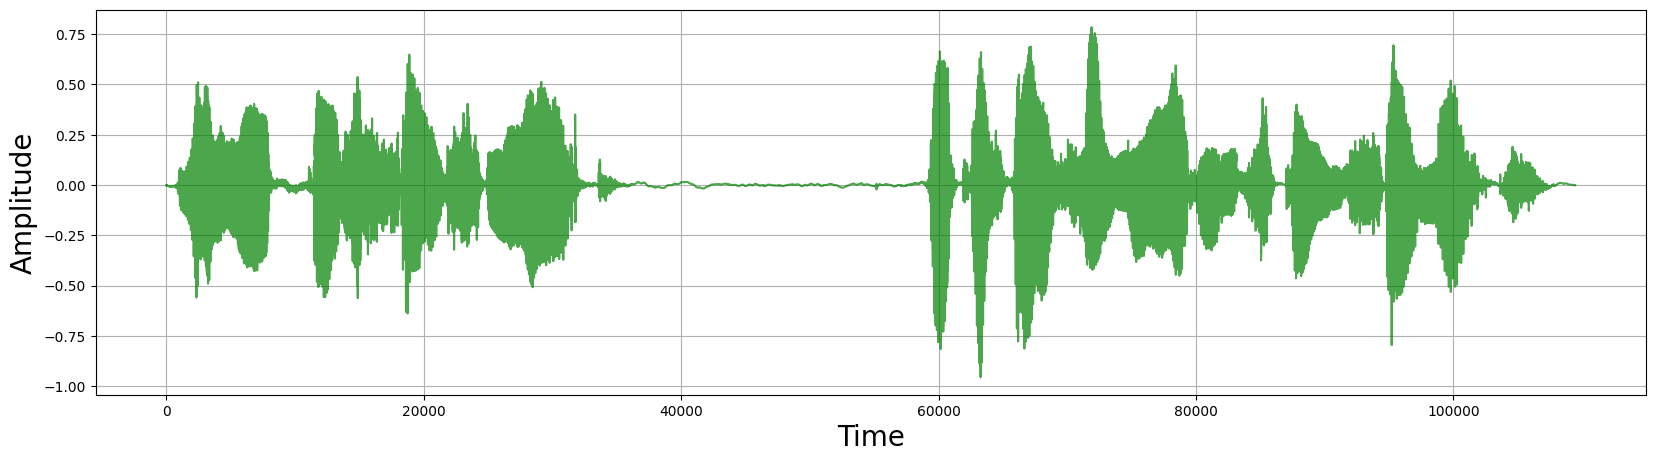

In [ ]:
visualize_audio(augumented_wav_4)

# Добавление фонового шума

Представим, что у нас есть сэмплы шума, такие как шум улицы, машины, кафе. Тогда мы можем добавить его на фон, чтобы сделать модель более устойчивой к этому шуму.

Подробнее:

    1) https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
    2) https://arxiv.org/pdf/1808.00563.pdf (3.1 chapter)

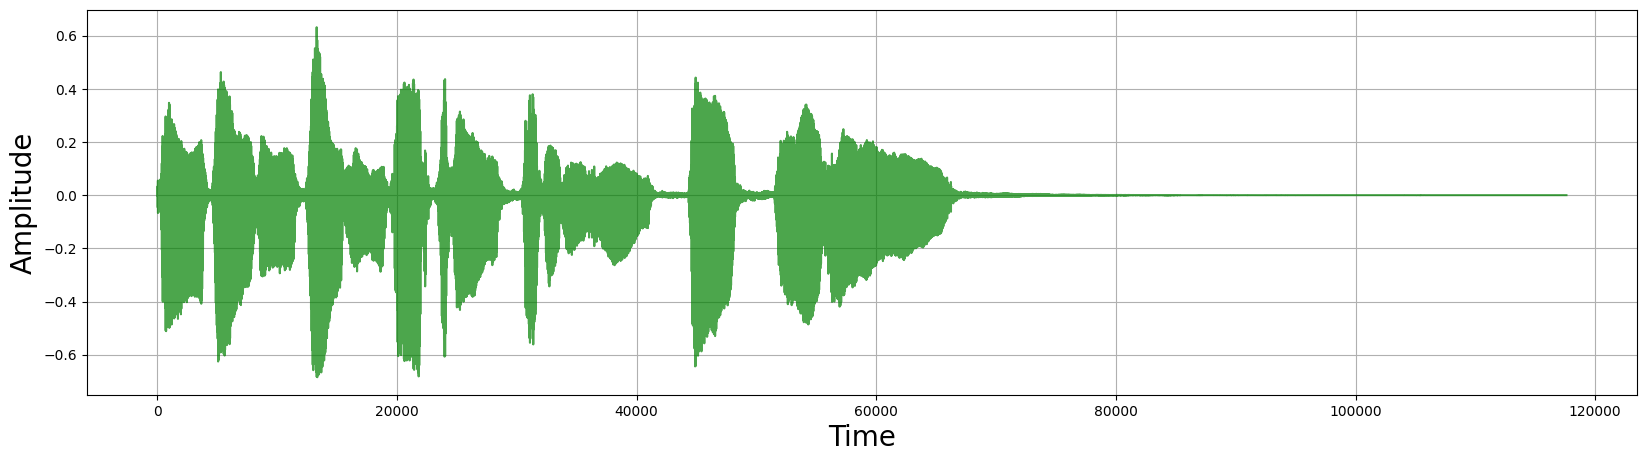

In [ ]:
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)

noise = y

visualize_audio(torch.from_numpy(noise))

In [ ]:
noize_level = torch.Tensor([20])  # [0, 40]

noize_energy = torch.norm(torch.from_numpy(noise))
audio_energy = torch.norm(wav)

alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 20)

noise = noise[..., :wav.shape[1]]

augumented_wav_6 = wav + alpha * torch.from_numpy(noise)

# In some cases the resulting sound may go beyond [-1, 1]
# So, clamp it :)
augumented_wav_6 = torch.clamp(augumented_wav_6, -1, 1)

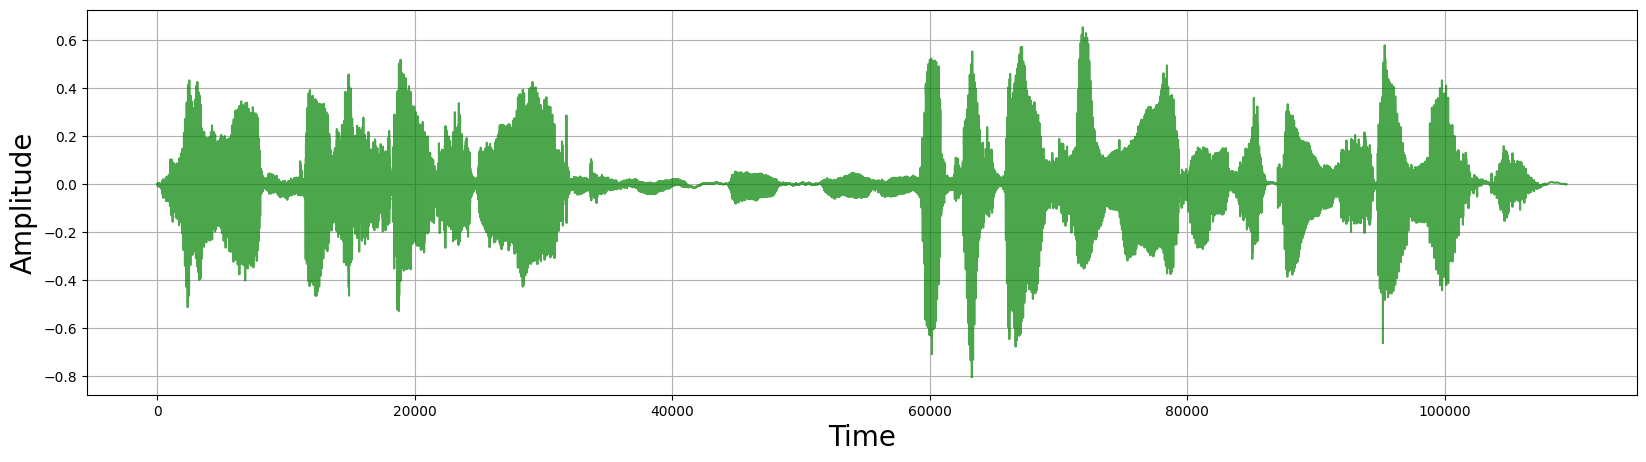

In [ ]:
visualize_audio(augumented_wav_6)

# Аугментации над спектром (Time/Freq masking, Cutout)
Так как мел спектрограмма - это изображение, мы може применить к ней некоторые аугментации из компьютерного зрения.

Подробнее: https://arxiv.org/pdf/1904.08779.pdf

In [ ]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(wav)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()

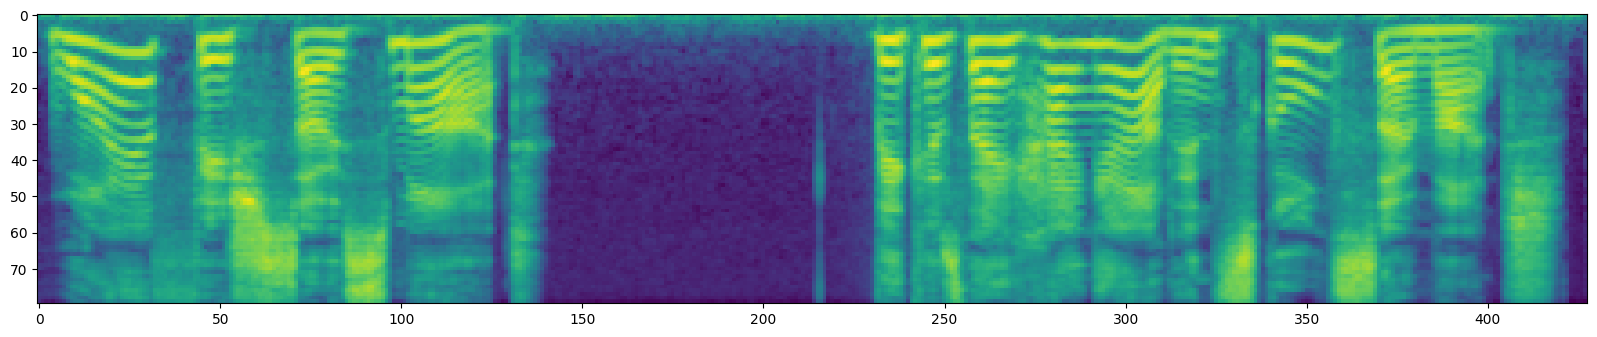

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(log_mel_spectrogram)
plt.show()

`torchaudio.transforms.FrequencyMasking` добавляет горизонтальную полосу `torchaudio.transforms.TimeMasking` - вертикальную полосу.

Так же можно объединить последовательно несколько аугментаций.

In [ ]:
specaug = nn.Sequential(
    torchaudio.transforms.FrequencyMasking(20),
    torchaudio.transforms.TimeMasking(100),
)

In [ ]:
augumented_log_mel_spectrogram = specaug(log_mel_spectrogram)

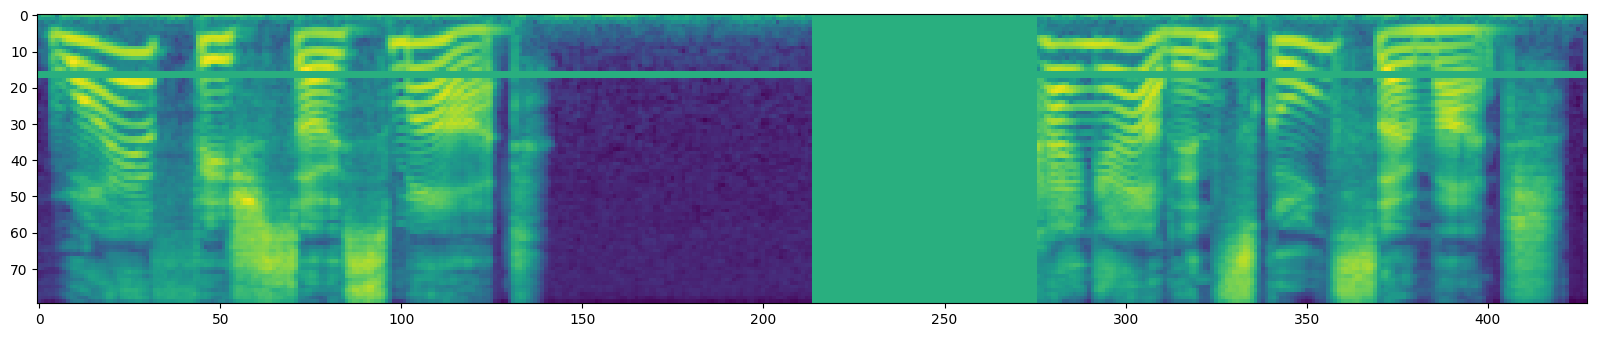

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(augumented_log_mel_spectrogram)
plt.show()